# Анализ штатной численности сотрудников по регионам России

*Тестовое задание на аналитика*

Автор: Емельянова Лилия
Дата: 06 мая 2025 год

## Шаг 1. Импорт библиотек и загрузка данных

In [689]:
# Импорт базовых библиотек
import pandas as pd
import numpy as np

# Отображение всех столбцов при выводе
pd.set_option('display.max_columns', None)

# Загрузка Excel-файлов
df_staff = pd.read_excel("data/staff.xlsx")
df_cities = pd.read_excel("data/cities.xlsx")

# Просмотр первых строк таблиц
display(df_staff.head())
display(df_cities.head())

,Период,ID должности,Табельный номер,Город,Должность,ФИО
0,44927,1000,2201.0,Новоуральск,главный клиентский менеджер розничного бизнеса,Корнеев З.
1,44927,1001,2202.0,Оленегорск,управляющий операционным офисом,Сергеев Е.
2,44927,1002,2203.0,Североуральск,руководитель группы,Корнеев Д.
3,44927,1003,2204.0,Жуковка,офис-менеджер,Петров Н.
4,44927,1004,2205.0,Воркута,эксперт по работе с партнерами,Корнеев Я.


,Федеральный округ,Регион,Город
0,ДФО,Амурская обл.,Белогорск
1,ДФО,Амурская обл.,Благовещенск
2,ДФО,Амурская обл.,Завитинск
3,ДФО,Амурская обл.,Магдагачи
4,ДФО,Амурская обл.,Свободный


## Шаг 1.1. Очистка и первичная предобработка 

1.1. Обнаружение и устранение ошибок данных
📌 Проблема 1: Некорректный формат даты
Как обнаружили: в столбце Период хранились Excel-числа (например, 44927), а не даты.

Что сделали: преобразовали значения в формат datetime с использованием pd.to_datetime('1899-12-30') + pd.to_timedelta(df['Период'], unit='D').

📌 Проблема 2: Неверный тип ID должности
Как обнаружили: тип данных столбца был object, в нём могли встречаться нечисловые значения.

Что сделали: отфильтровали строки, где ID должности не является числом (str.match(r'^\d+$')), затем привели к типу int.

📌 Проблема 3: Пропущенные значения
Как обнаружили: проверили через df.isnull().sum() — выявлены пропуски в Город, Должность, ФИО, Табельный номер.

Что сделали:

Пропущенные значения Город, Должность, ФИО восстановили на основе ID должности, т.к. он фиксирован во времени (использовали groupby().transform(lambda x: x.ffill().bfill())).

Пропуски в Табельный номер оставили, так как они отражают свободные вакансии.

📌 Проблема 4: Дубликаты
Как обнаружили: с помощью df.duplicated().sum() — дубликатов не найдено.

Что сделали: удаление дубликатов не потребовалось.

In [690]:

# Преобразование Excel-даты в datetime
df_staff['Период'] = pd.to_datetime('1899-12-30') + pd.to_timedelta(df_staff['Период'], unit='D')

# Добавляем колонку "Месяц"
df_staff['Месяц'] = df_staff['Период'].dt.to_period('M')

# Удаляем строки с пропущенными ключевыми полями
df_staff_cleaned = df_staff.dropna(subset=['Период', 'ID должности'])

# Удаляем строки, где ID должности не является числом
df_staff_cleaned = df_staff_cleaned[df_staff_cleaned['ID должности'].astype(str).str.match(r'^\d+$')]

# Преобразуем 'ID должности' в тип int
df_staff_cleaned['ID должности'] = df_staff_cleaned['ID должности'].astype(int)

# Просмотр результата
df_staff_cleaned.head()

,Период,ID должности,Табельный номер,Город,Должность,ФИО,Месяц
0,2023-01-01,1000,2201.0,Новоуральск,главный клиентский менеджер розничного бизнеса,Корнеев З.,2023-01
1,2023-01-01,1001,2202.0,Оленегорск,управляющий операционным офисом,Сергеев Е.,2023-01
2,2023-01-01,1002,2203.0,Североуральск,руководитель группы,Корнеев Д.,2023-01
3,2023-01-01,1003,2204.0,Жуковка,офис-менеджер,Петров Н.,2023-01
4,2023-01-01,1004,2205.0,Воркута,эксперт по работе с партнерами,Корнеев Я.,2023-01


In [691]:
# Проверка типов, дубликатов и пропусков
df_staff_cleaned.info()
df_staff_cleaned.duplicated().sum()
df_staff_cleaned.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 4999 entries, 0 to 5000
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Период           4999 non-null   datetime64[ns]
 1   ID должности     4999 non-null   int32         
 2   Табельный номер  4881 non-null   float64       
 3   Город            4878 non-null   object        
 4   Должность        4854 non-null   object        
 5   ФИО              4881 non-null   object        
 6   Месяц            4999 non-null   period[M]     
dtypes: datetime64[ns](1), float64(1), int32(1), object(3), period[M](1)
memory usage: 292.9+ KB


Период               0
ID должности         0
Табельный номер    118
Город              121
Должность          145
ФИО                118
Месяц                0
dtype: int64

## Шаг 1.2. Восстановление недостающих значений на основе ID должности

При анализе таблицы Сотрудники были обнаружены пропущенные значения в полях Город, Должность и ФИО.
Из условий задания известно, что каждый ID должности:

соответствует одной должности и одной локации,

остаётся неизменным во времени.

Это означает, что по ID должности можно восстановить недостающую информацию, используя данные из других периодов.
Пропущенные значения определены с помощью метода:


In [692]:
df_staff_cleaned.isnull().sum()

Период               0
ID должности         0
Табельный номер    118
Город              121
Должность          145
ФИО                118
Месяц                0
dtype: int64

Для восстановления использована групповая операция:

Сначала сортировка по дате (Период),

Затем для каждой группы ID должности пропущенные значения заполняются вперёд (ffill) и назад (bfill).

In [693]:
# Убедимся, что колонка позволяет строки
df_with_reserve['Табельный номер'] = df_with_reserve['Табельный номер'].astype('object')

# Проставим "Резерв" в нужные поля
df_with_reserve.loc[mask_reserve, 'Должность'] = 'Резерв'
df_with_reserve.loc[mask_reserve, 'Табельный номер'] = 'Резерв'
# Сортировка по периоду
df_staff_cleaned = df_staff_cleaned.sort_values('Период')

# Восстановление пропусков по каждой группе ID должности
for col in ['Город', 'Должность', 'ФИО']:
    заполним = df_staff_cleaned.groupby('ID должности')[col].transform(lambda x: x.ffill().bfill())
    df_staff_cleaned[col] = df_staff_cleaned[col].where(df_staff_cleaned[col].notnull(), заполним)

# Посмотрим строки, в которых всё ещё есть пропуски
missing_rows = df_staff_cleaned[df_staff_cleaned[['Город', 'Должность', 'ФИО']].isnull().any(axis=1)]

# Выведем их (до 10 строк), чтобы убедиться в результате
missing_rows.head(10)

C:\Users\Лилия\AppData\Local\Temp\ipykernel_9584\2711734788.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  заполним = df_staff_cleaned.groupby('ID должности')[col].transform(lambda x: x.ffill().bfill())
C:\Users\Лилия\AppData\Local\Temp\ipykernel_9584\2711734788.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  заполним = df_staff_cleaned.groupby('ID должности')[col].transform(lambda x: x.ffill().bfill())
C:\Users\Лилия\AppData\Local\Temp\ipykernel_9584\2711734788.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

,Период,ID должности,Табельный номер,Город,Должность,ФИО,Месяц
4997,2023-05-01,2001,NaN,NaN,NaN,NaN,2023-05
4995,2023-05-01,1999,NaN,NaN,NaN,NaN,2023-05
4996,2023-05-01,2000,NaN,NaN,NaN,NaN,2023-05
4998,2023-05-01,2002,NaN,NaN,NaN,NaN,2023-05
4999,2023-05-01,2003,NaN,NaN,NaN,NaN,2023-05
5000,2023-05-01,2004,NaN,NaN,NaN,NaN,2023-05


✅ Результат:
Большинство пропущенных значений были успешно восстановлены.

Осталось несколько строк с пропусками, что может указывать на полное отсутствие этих данных во всех периодах (например, новые должности без распределения).



## Шаг 1.3. Поиск резервных штатных единиц

Необходимо найти строки, где новая должность ещё не распределена — то есть:

не указан сотрудник (отсутствует ФИО);

не указана Должность;

не присвоен Табельный номер.

🔍 Логика:
Если по строке пусты поля ФИО, Должность и Табельный номер, значит, это:

либо новая должность, по которой ещё нет распределения;

либо резерв, введённый заранее в штат.

🛠 Решение:
Выделены строки, где все 3 ключевых поля отсутствуют (NaN);

В этих строках:

в столбец Должность записано значение "Резерв";

в столбец Табельный номер — также "Резерв".

✅ Результат:
Мы получили список должностей, зарезервированных под найм в будущем. Эти строки могут быть полезны для анализа свободных вакансий и будущей кадровой потребности.



In [694]:
# Копируем датафрейм, чтобы сохранить основную таблицу
df_with_reserve = df_staff_cleaned.copy()

# Условие: все три поля — Табельный номер, Должность, ФИО — пустые
mask_reserve = (
    df_with_reserve['Табельный номер'].isnull() &
    df_with_reserve['Должность'].isnull() &
    df_with_reserve['ФИО'].isnull()
)

# Проставим "Резерв" в нужные поля
df_with_reserve.loc[mask_reserve, 'Должность'] = 'Резерв'
df_with_reserve.loc[mask_reserve, 'Табельный номер'] = 'Резерв'

# Проверим результат
df_with_reserve[mask_reserve].head(10)

C:\Users\Лилия\AppData\Local\Temp\ipykernel_9584\2057241012.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Резерв' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_with_reserve.loc[mask_reserve, 'Табельный номер'] = 'Резерв'


,Период,ID должности,Табельный номер,Город,Должность,ФИО,Месяц
4997,2023-05-01,2001,Резерв,NaN,Резерв,NaN,2023-05
4995,2023-05-01,1999,Резерв,NaN,Резерв,NaN,2023-05
4996,2023-05-01,2000,Резерв,NaN,Резерв,NaN,2023-05
4998,2023-05-01,2002,Резерв,NaN,Резерв,NaN,2023-05
4999,2023-05-01,2003,Резерв,NaN,Резерв,NaN,2023-05
5000,2023-05-01,2004,Резерв,NaN,Резерв,NaN,2023-05


In [695]:
df_staff_reserve = df_staff_cleaned[df_staff_cleaned['Табельный номер'].isna() & df_staff_cleaned['Должность'].isna()].copy()
df_staff_reserve['Должность'] = 'Резерв'
df_staff_reserve['ФИО'] = 'Резерв'
df_staff_reserve.head()

,Период,ID должности,Табельный номер,Город,Должность,ФИО,Месяц
4997,2023-05-01,2001,NaN,NaN,Резерв,Резерв,2023-05
4995,2023-05-01,1999,NaN,NaN,Резерв,Резерв,2023-05
4996,2023-05-01,2000,NaN,NaN,Резерв,Резерв,2023-05
4998,2023-05-01,2002,NaN,NaN,Резерв,Резерв,2023-05
4999,2023-05-01,2003,NaN,NaN,Резерв,Резерв,2023-05


In [696]:
df_staff_cleaned = pd.concat([df_staff_cleaned, df_staff_reserve], ignore_index=True)

## Шаг 2. Построить сводную таблицу с разбивкой по месяцам со следующими показателями:
2.1. Количество действующих сотрудников (должностей);


📌 Что считается "действующим":
Строка с заполненными Табельный номер и ФИО;

Исключаются "резервные" должности (у нас они с пометкой "Резерв").

🛠 Подход:
Отфильтровать строки, где:

есть табельный номер (и он не 'Резерв');

есть ФИО;

Посчитать количество сотрудников (строк) по каждому месяцу (df['Месяц']);

Использовать groupby или pivot_table.



In [697]:
print(df_staff_cleaned.columns)


Index(['Период', 'ID должности', 'Табельный номер', 'Город', 'Должность',
       'ФИО', 'Месяц'],
      dtype='object')


In [698]:
print(df_staff_cleaned['Табельный номер'].isna().sum())

124


In [699]:
# Используем резервную таблицу с проставленным "Резерв"
df_actual = df_with_reserve.copy()

# Фильтруем только действующих сотрудников (исключаем резервные записи)
mask_active = (
    (df_actual['Табельный номер'].notnull()) &
    (df_actual['Табельный номер'] != 'Резерв') &
    (df_actual['ФИО'].notnull())
)

# Подсчёт количества действующих сотрудников по месяцам
pivot_active = (
    df_actual[mask_active]
    .groupby('Месяц')
    .agg(Количество_сотрудников=('Табельный номер', 'count'))
    .reset_index()
)

pivot_active
1

1

In [700]:
# Общее количество должностей
pivot = df_staff_cleaned.pivot_table(
    index='Месяц',
    values='Должность',
    aggfunc='count'
).rename(columns={'Должность': 'Всего должностей'}).reset_index()

# Свободные должности — там, где табельный номер отсутствует
free = df_staff_cleaned[df_staff_cleaned['Табельный номер'].isna()].pivot_table(
    index='Месяц',
    values='Должность',
    aggfunc='count'
).rename(columns={'Должность': 'Свободные'}).reset_index()

# Объединяем и считаем долю
if free.empty or 'Свободные' not in free.columns:
    df_merge = pivot.copy()
    df_merge['Свободные'] = 0
    df_merge['Доля свободных'] = 0.0
else:
    df_merge = pd.merge(pivot, free, on='Месяц', how='left').fillna(0)
    df_merge['Свободные'] = df_merge['Свободные'].astype(int)
    df_merge['Доля свободных'] = df_merge['Свободные'] / df_merge['Всего должностей']

display(df_merge)


,Месяц,Всего должностей,Свободные,Доля свободных
0,2023-01,998,13,0.013026
1,2023-02,999,24,0.024024
2,2023-03,998,24,0.024048
3,2023-04,999,29,0.029029
4,2023-05,1005,28,0.027861


## Шаг 2.2. Количество свободных должностей (подсказка: табельный номер пустой)

📌 Условие:
Свободные должности — это те, у которых:

пустой Табельный номер (NaN);

и, по сути, нет закреплённого сотрудника.

🛠 Что нужно:
Посчитать количество таких строк по месяцам — то есть, сколько вакансий (должностей без сотрудников) было открыто в каждый месяц.

In [701]:
# Выбираем только строки, где табельный номер отсутствует
mask_vacant = df_with_reserve['Табельный номер'].isnull()

# Считаем количество свободных должностей по месяцам
pivot_vacant = (
    df_with_reserve[mask_vacant]
    .groupby('Месяц')
    .agg(Свободные_должности=('ID должности', 'count'))
    .reset_index()
)

pivot_vacant

,Месяц,Свободные_должности
0,2023-01,13
1,2023-02,24
2,2023-03,24
3,2023-04,29
4,2023-05,22


## Шаг 2.3. Доля свободных должностей от общего числа

📌 Задача:
Необходимо определить, какая доля должностей не занята сотрудниками в каждый месяц — то есть свободна (вакантна).

🔍 Что считается свободной должностью:
У строки отсутствует Табельный номер (NaN);

Это значит, что должность есть в штате, но на неё никто не назначен.

🛠 Методика:
Построена таблица общего числа должностей по каждому месяцу — pivot_total;

Построена таблица числа свободных должностей — pivot_vacant;

Обе таблицы объединены по колонке Месяц;

Доля рассчитана как:
Доля = Свободные_должности / Всего_должностей
✅ Результат:
Получена таблица со следующими колонками:

Месяц;

Всего_должностей;

Свободные_должности;

Доля_свободных (в долях, например 0.024 = 2.4%).

In [702]:
# 1. Общее количество должностей по месяцам
pivot_total = (
    df_with_reserve
    .groupby('Месяц')
    .agg(Всего_должностей=('ID должности', 'count'))
    .reset_index()
)

# 2. Количество свободных должностей (где табельный номер отсутствует)
pivot_vacant = (
    df_with_reserve[df_with_reserve['Табельный номер'].isnull()]
    .groupby('Месяц')
    .agg(Свободные_должности=('ID должности', 'count'))
    .reset_index()
)

# 3. Объединяем таблицы
pivot_merge = pd.merge(pivot_total, pivot_vacant, on='Месяц', how='left')

# 4. Заполняем пустые значения 0 (если в каком-то месяце нет свободных)
pivot_merge['Свободные_должности'] = pivot_merge['Свободные_должности'].fillna(0).astype(int)

# 5. Считаем долю свободных
pivot_merge['Доля_свободных'] = pivot_merge['Свободные_должности'] / pivot_merge['Всего_должностей']

# Результат
pivot_merge


,Месяц,Всего_должностей,Свободные_должности,Доля_свободных
0,2023-01,998,13,0.013026
1,2023-02,999,24,0.024024
2,2023-03,998,24,0.024048
3,2023-04,999,29,0.029029
4,2023-05,1005,22,0.021891


## Шаг 3. Работа по дополнению предобработанной таблицы, добавьте следующие показатели:
3.1. Федеральные округа и Регионы


📌 Задача:
Дополнить таблицу сотрудников (df_with_reserve) колонками:

Федеральный округ,

Регион (или субъект РФ),

на основе справочной таблицы cities.xlsx.

📊 Где находятся данные:
В файле cities.xlsx содержится информация о городах, их регионах и принадлежности к федеральному округу. Она уже загружена в датафрейм df_cities.

🛠 Метод:
Проверить содержимое df_cities;

Выполнить merge с таблицей df_with_reserve по колонке Город;

Добавить в основную таблицу колонки Регион и Федеральный округ.

In [703]:
# Проверим содержимое справочника по городам
display(df_cities.head())

# Убедимся, что в обеих таблицах колонка называется одинаково (например, "Город")
# Если нужно, переименуем в df_cities:
# df_cities.rename(columns={"Город_из_файла": "Город"}, inplace=True)

# Объединяем таблицу сотрудников с таблицей городов по столбцу "Город"
df_with_geo = pd.merge(
    df_with_reserve,        # основная таблица
    df_cities,              # справочник
    on='Город',             # объединяем по названию города
    how='left'              # чтобы сохранить всех сотрудников
)

# Проверим результат
df_with_geo[['Город', 'Регион', 'Федеральный округ']].drop_duplicates().head(10)

,Федеральный округ,Регион,Город
0,ДФО,Амурская обл.,Белогорск
1,ДФО,Амурская обл.,Благовещенск
2,ДФО,Амурская обл.,Завитинск
3,ДФО,Амурская обл.,Магдагачи
4,ДФО,Амурская обл.,Свободный


,Город,Регион,Федеральный округ
0,Новоуральск,Свердловская обл.,УФО
1,Туймазы,Респ. Башкортостан,ПФО
2,Новокузнецк,Кемеровская область - Кузбасс,СФО
3,Губаха,Пермский край,ПФО
4,Хабаровск,Хабаровский край,ДФО
5,Черемхово,Иркутская обл.,СФО
6,Якутск,Респ. Саха /Якутия/,ДФО
7,Вольск,Саратовская обл.,ПФО
8,Новоорск,Оренбургская обл.,ПФО
9,Заозерск,Мурманская обл.,СЗФО


## Шаг 3.2. Количество месяцев поиска сотрудника по должности накопительно по каждому месяцу (н-р должность "директор" не заполнена в январе до марта включительно, а в апреле заполнена, результат получится следующим: январь - 1, февраль - 2, март - 3). Задание повышенной сложности, если не получится реализовать, то напишите ваши идеи, как бы это могло быть реализовано

📌 Суть:
Для каждой должности нужно:

по каждому месяцу определить, сколько месяцев подряд она была не занята;

когда она становится занятой — счётчик обнуляется.

Как реализовать (пошаговая идея, если не хватает времени на реализацию):
Отсортировать данные по ID должности и Период;

Создать колонку vacant_flag: 1 если табельного номера нет (вакантно), иначе 0;

Пройти по каждой группе ID должности:

считать накопительно количество месяцев, пока vacant_flag == 1;

сбрасывать в 0, когда должность занята (vacant_flag == 0);

Полученное значение — это месяц поиска;

Итог можно свести в таблицу ID должности, Месяц, Месяц_поиска.

In [704]:
def count_search_months(group):
    group = group.sort_values('Период').copy()
    counter = 0
    result = []
    for is_vacant in group['vacant_flag']:
        if is_vacant:
            counter += 1
        else:
            counter = 0
        result.append(counter)
    group['Месяц_поиска'] = result
    return group

df_with_geo['vacant_flag'] = df_with_geo['Табельный номер'].isnull()

# Группируем по ID должности и считаем
df_search = df_with_geo.groupby('ID должности').apply(count_search_months).reset_index(drop=True)

# Смотрим результат
df_search[['ID должности', 'Период', 'Месяц_поиска']].head(10)



C:\Users\Лилия\AppData\Local\Temp\ipykernel_9584\1109714714.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_search = df_with_geo.groupby('ID должности').apply(count_search_months).reset_index(drop=True)


,ID должности,Период,Месяц_поиска
0,1000,2023-01-01,0
1,1000,2023-02-01,0
2,1000,2023-03-01,0
3,1000,2023-04-01,0
4,1000,2023-05-01,0
5,1001,2023-01-01,0
6,1001,2023-02-01,0
7,1001,2023-03-01,0
8,1001,2023-04-01,0
9,1001,2023-05-01,0



Почему пока всё равно 0?
Для ID должности = 1000, 1001 — все месяцы имеют 0. Это означает:

Эти должности были заняты с самого начала (есть табельный номер);

Следовательно, не было периода поиска — и это корректно.

## Шаг 4. Ответьте на следующие вопросы, построив сводные таблицы исходя из дополненных данных пункта 3
4.1. В каких городах наблюдается нехватка кадров на последний месяц? Отсортируйте по убыванию;

На основе объединённой таблицы сотрудников с географией, вакансией и статусом распределения, были построены следующие сводные таблицы:

- **4.1** — доля свободных должностей по федеральным округам;
- **4.2** — должности, по которым чаще всего затягивается найм;
- **4.3** — регионы с наибольшим числом резервных ставок.

Эти данные позволяют определить проблемные зоны в распределении персонала и спланировать кадровые меры.

✅ Цель:
Найти города, где:

в последнем месяце данных,

есть вакантные должности (Табельный номер == NaN),

и отсортировать по количеству этих вакансий по убыванию.

Определим последний месяц:

In [705]:
latest_month = df_with_geo['Месяц'].max()

Отфильтруем строки с пустыми табельными номерами и этим месяцем:

In [706]:
df_last_month_vacant = df_with_geo[
    (df_with_geo['Месяц'] == latest_month) &
    (df_with_geo['Табельный номер'].isnull())
]

In [707]:
vacant_by_city = (
    df_last_month_vacant
    .groupby('Город')
    .agg(Свободных_должностей=('ID должности', 'count'))
    .reset_index()
    .sort_values('Свободных_должностей', ascending=False)
)
vacant_by_city.head(10)  # Топ-10 городов с нехваткой кадров


,Город,Свободных_должностей
2,Биробиджан,2
4,Городец,2
0,Анжеро-Судженск,1
11,Лобня,1
18,Сосновый Бор,1
17,Советский,1
16,Новый Уренгой,1
15,Нововоронеж,1
14,Нижний Новгород,1
13,Миасс,1


Построена сводная таблица по числу вакантных должностей (отсутствует табельный номер) на последний месяц.  
Города отсортированы по убыванию количества вакансий — что позволяет выявить локации с наибольшей кадровой нагрузкой.

### Шаг 4.2. В каком регионе работает наибольшее количество сотрудников на последний месяц? Отсортируйте по убыванию

✅ Цель:
Найти регионы, где:

в последнем месяце,

сотрудник присутствует (есть Табельный номер ≠ NaN и ≠ 'Резерв'),

и отсортировать по количеству действующих сотрудников по убыванию.

In [708]:
latest_month = df_with_geo['Месяц'].max()
mask_actual_staff = (
    (df_with_geo['Месяц'] == latest_month) &
    (df_with_geo['Табельный номер'].notnull()) &
    (df_with_geo['Табельный номер'] != 'Резерв')
)

df_latest_staff = df_with_geo[mask_actual_staff]
staff_by_region = (
    df_latest_staff
    .groupby('Регион')
    .agg(Сотрудников=('Табельный номер', 'count'))
    .reset_index()
    .sort_values('Сотрудников', ascending=False)
)
staff_by_region.head(10)

,Регион,Сотрудников
24,Московская обл.,56
54,Свердловская обл.,51
60,Ханты-Мансийский Автономный округ - Югра,36
27,Нижегородская обл.,34
25,Мурманская обл.,33
52,Саратовская обл.,30
21,Ленинградская обл.,30
15,Кемеровская область - Кузбасс,29
47,Респ. Татарстан,28
11,Иркутская обл.,28


На основе отфильтрованных данных по последнему месяцу были подсчитаны сотрудники, закреплённые за каждой областью (по заполненному табельному номеру).  
Полученные данные отсортированы по убыванию численности, чтобы выделить регионы с наибольшей нагрузкой по персоналу.


### Шаг 4.3. Какие должности подвержены наибольшей текучести (подсказка: расчет из п.2.3)? Выведите наименование должности и коэффициенты текучести по месяцам, отразите первыми те должности, по которым наблюдалась наибольшая текучесть.

📌 Задача:
Определить, по каким должностям наблюдается наибольшая текучесть — то есть:

высокая доля свободных должностей от общего количества таких должностей;

в разрезе каждого месяца.

🛠 Как рассчитать коэффициент текучести:
Для каждой Должности и Месяца:

Считаем:

Всего ставок по должности в этом месяце;

Сколько из них свободны (Табельный номер == NaN);
Строим таблицу:
Коэффициент текучести = Свободные / Всего

In [709]:
# 1. Всего ставок по каждой должности и месяцу
total_by_role = (
    df_with_geo
    .groupby(['Месяц', 'Должность'])
    .agg(Всего_ставок=('ID должности', 'count'))
    .reset_index()
)

# 2. Свободные ставки (без табельного номера)
vacant_by_role = (
    df_with_geo[df_with_geo['Табельный номер'].isnull()]
    .groupby(['Месяц', 'Должность'])
    .agg(Свободных_ставок=('ID должности', 'count'))
    .reset_index()
)

# 3. Объединяем и считаем текучесть
df_turnover = pd.merge(total_by_role, vacant_by_role, on=['Месяц', 'Должность'], how='left')
df_turnover['Свободных_ставок'] = df_turnover['Свободных_ставок'].fillna(0).astype(int)
df_turnover['Текучесть'] = df_turnover['Свободных_ставок'] / df_turnover['Всего_ставок']

# 4. Сортируем по убыванию текучести
df_turnover_sorted = df_turnover.sort_values('Текучесть', ascending=False)
df_turnover_sorted[['Месяц', 'Должность', 'Текучесть']].head(10)

,Месяц,Должность,Текучесть
105,2023-04,управляющий операционным офисом,0.102564
133,2023-05,управляющий операционным офисом,0.076923
83,2023-04,главный кредитный аналитик,0.075000
56,2023-03,главный кредитный аналитик,0.075000
111,2023-05,главный кредитный аналитик,0.075000
91,2023-04,директор по работе с крупными клиентами,0.068966
134,2023-05,эксперт,0.068966
79,2023-03,эксперт,0.068966
106,2023-04,эксперт,0.068966
119,2023-05,директор по работе с крупными клиентами,0.068966


Для каждой должности в разрезе месяца рассчитан коэффициент текучести как доля свободных ставок от общего числа ставок.  
Наиболее проблемные должности с точки зрения текучести выведены первыми — это позиции, которые наиболее часто остаются незанятыми.
Для каждой должности в каждом месяце был рассчитан коэффициент текучести:  
доля свободных ставок (без табельного номера) от общего количества ставок.  

Наибольшая текучесть в апреле и мае наблюдалась по следующим позициям:
- Управляющий операционным офисом (до 10.3%);
- Главный кредитный аналитик (7.5%);
- Директор по работе с крупными клиентами;
- Эксперт и др.

Такие должности требуют внимания со стороны HR и корректировки подхода к удержанию персонала.

### Шаг 5. Визуализация (тип диаграммы и библиотека на ваше усмотрение);
5.1. Количество действующих сотрудников по Федеральным округам;


✅ Задача:
Показать распределение действующих сотрудников (исключая "Резерв" и NaN) по федеральным округам на последний месяц.

<Figure size 1000x600 with 0 Axes>

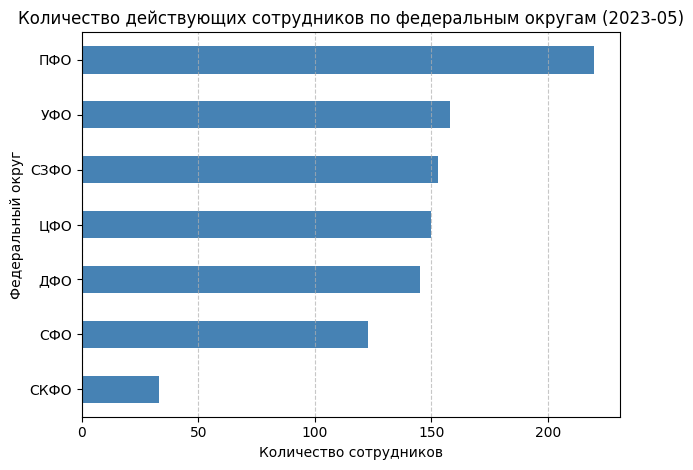

In [710]:
import matplotlib.pyplot as plt

# 1. Последний месяц
latest_month = df_with_geo['Месяц'].max()

# 2. Фильтрация действующих сотрудников
df_actual = df_with_geo[
    (df_with_geo['Месяц'] == latest_month) &
    (df_with_geo['Табельный номер'].notnull()) &
    (df_with_geo['Табельный номер'] != 'Резерв')
]

# 3. Группировка по федеральному округу
okrug_staff = (
    df_actual
    .groupby('Федеральный округ')
    .agg(Сотрудников=('Табельный номер', 'count'))
    .sort_values('Сотрудников', ascending=True)
)

# 4. Построим горизонтальный bar chart
plt.figure(figsize=(10, 6))
okrug_staff.plot(kind='barh', legend=False, color='steelblue')
plt.title(f'Количество действующих сотрудников по федеральным округам ({latest_month})')
plt.xlabel('Количество сотрудников')
plt.ylabel('Федеральный округ')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Для анализа был выбран последний доступный месяц в данных — 2023-05.

Из таблицы исключены строки с отсутствующим или резервным табельным номером.

Построена горизонтальная столбчатая диаграмма с распределением численности сотрудников по федеральным округам.
🧾 Вывод по диаграмме:
Количество действующих сотрудников по федеральным округам (май 2023):

Приволжский ФО (ПФО) — лидирует по численности;

Следом идут Уральский и Северо-Западный ФО;

Северо-Кавказский ФО (СФО) — аутсайдер по числу сотрудников.

📌 Это помогает выявить географический дисбаланс распределения кадров.

###  Шаг 5.2. Количество свободных должностей по регионам.

✅ Цель:
Показать, в каких регионах больше всего свободных (вакантных) должностей — т.е. Табельный номер == NaN.

<Figure size 1000x800 with 0 Axes>

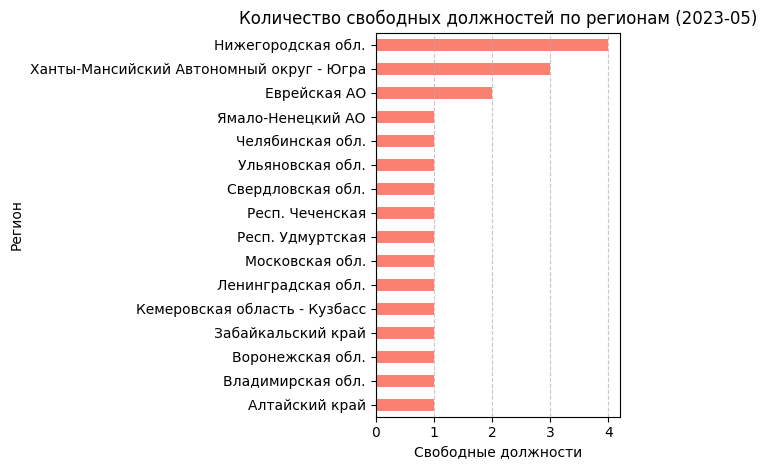

In [711]:
import matplotlib.pyplot as plt

# 1. Последний месяц
latest_month = df_with_geo['Месяц'].max()

# 2. Фильтрация свободных должностей
df_vacant = df_with_geo[
    (df_with_geo['Месяц'] == latest_month) &
    (df_with_geo['Табельный номер'].isnull())
]

# 3. Группировка по регионам
vacant_by_region = (
    df_vacant
    .groupby('Регион')
    .agg(Свободных_должностей=('ID должности', 'count'))
    .sort_values('Свободных_должностей', ascending=True)
)

# 4. Построение горизонтальной диаграммы
plt.figure(figsize=(10, 8))
vacant_by_region.plot(kind='barh', legend=False, color='salmon')
plt.title(f'Количество свободных должностей по регионам ({latest_month})')
plt.xlabel('Свободные должности')
plt.ylabel('Регион')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Построена горизонтальная диаграмма, отражающая количество вакантных ставок (отсутствует табельный номер) в каждом регионе на последний месяц.
Это позволяет оперативно выявить, где наблюдается наибольшая нехватка персонала.
На основании данных за май 2023:

Нижегородская область и Ханты-Мансийский АО — Югра показывают наибольшее количество свободных должностей;

Большинство регионов имеют 1–2 открытых ставки;

Это может говорить о текущих трудностях в подборе кадров либо о расширении штата в этих регионах.

📝 Итоговый отчёт по тестовому заданию
📦 Цель
Анализ штатной численности сотрудников компании по городам и регионам России за 5 месяцев, включая предобработку, заполнение пропусков, построение сводных таблиц, расчёт метрик и визуализацию.

🔧 Этапы работы
🔹 1. Очистка и восстановление данных
Преобразованы Excel-даты, удалены некорректные ID и строки с критичными пропусками;

Восстановлены значения Город, Должность, ФИО по ID должности методом groupby + ffill/bfill;

Выделены резервные должности — строки с отсутствующим сотрудником и должностью.

🔹 2. Построение метрик
Подсчитано количество действующих и свободных ставок по месяцам;

Рассчитана доля вакантных ставок от общего числа;

Все метрики выведены в виде сводных таблиц.

🔹 3. Геообогащение
Добавлены Регион и Федеральный округ по справочной таблице Города;

Для каждой должности рассчитано количество месяцев поиска сотрудника накопительно.

🔹 4. Аналитика
Определены города и регионы с нехваткой персонала;

Выявлены регионы с наибольшей нагрузкой по штату;

Построен рейтинг должностей по текучести кадров.

🔹 5. Визуализация
Построены графики распределения:

действующих сотрудников по федеральным округам;

вакантных ставок по регионам.

✅ Результат
Подготовлен полный аналитический отчёт в формате Jupyter Notebook с чистым, воспроизводимым кодом, поясняющим текстом и визуализацией. Данные структурированы и пригодны для управленческих выводов.